# NESM Python Workshop Part 3


## Overview

Goals:
We can't cover every use case in detail so the main goals here are:
1. Demonstrate that you can do microscopy analysis completely from python
2. Give a quick tour of the some of the many open source libs (set you up for future success)
3. Go over some domain specific examples
    - reinforce the numpy we learned in part 1
    - Show power of the open source ecosystem
    - Building blocks are all here and numpy is the commmon language of these tools

- Microscopy Image IO


### Scripts vs GUIs

## Image analysis tools

Python has a rich ecosystem of libraries
- [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html)
- [skimage](https://scikit-image.org/docs/dev/api/skimage.html)
- [sklearn](https://scikit-learn.org/stable/)
- [xarray](http://xarray.pydata.org/en/stable/)
- [pandas](https://pandas.pydata.org/)


Domain Specific tools:

- [hyperspy](https://hyperspy.org/hyperspy-doc/current/user_guide/intro.html)
- [microutil](https://github.com/Hekstra-Lab/microutil)
- 
**Deep Learning:**
The two world class libraries are both primarily python:
- https://pytorch.org/
- https://www.tensorflow.org/  (we'll see an example later)



Visualization

## [Napari](https://napari.org/)
    
    
The future of microscopy image visualization. 

- Tools like Matplotlib will always have a place in the workflow, but Napari is a best in class image viewer that also 

GPU accelerated
Core developers work in bioimaging
Open source with a strong community of contributors
vs hyperslicer - 


https://www.youtube.com/watch?v=VXdFOcBCto4


Let's you work anywhere on the spectrum from pure gui to pure script no interactivity.

## IO

Not always a fully solved problem due to to proprietary formats. 

Libraries exist where people have put in the work to read all the possible types of images. 


Rock solid base: https://github.com/cgohlke/tifffile  
https://github.com/tlambert03/ome-types  
The future (and maybe also the now?): https://allencellmodeling.github.io/aicsimageio/  


Per https://ngff.openmicroscopy.org/latest/ [zarr](https://zarr.readthedocs.io/en/stable/) will be the basis of the next generation file format.

In [ ]:
# Show a basic napari demo

In [ ]:
%matplotlib widget
import xarray as xr
from mpl_interactions import hyperslicer
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import tifffile
import numpy as np



# Looking at an Example SEM image

Kindly provided by JEOL.

We'd like to be able to reproduce something like this:

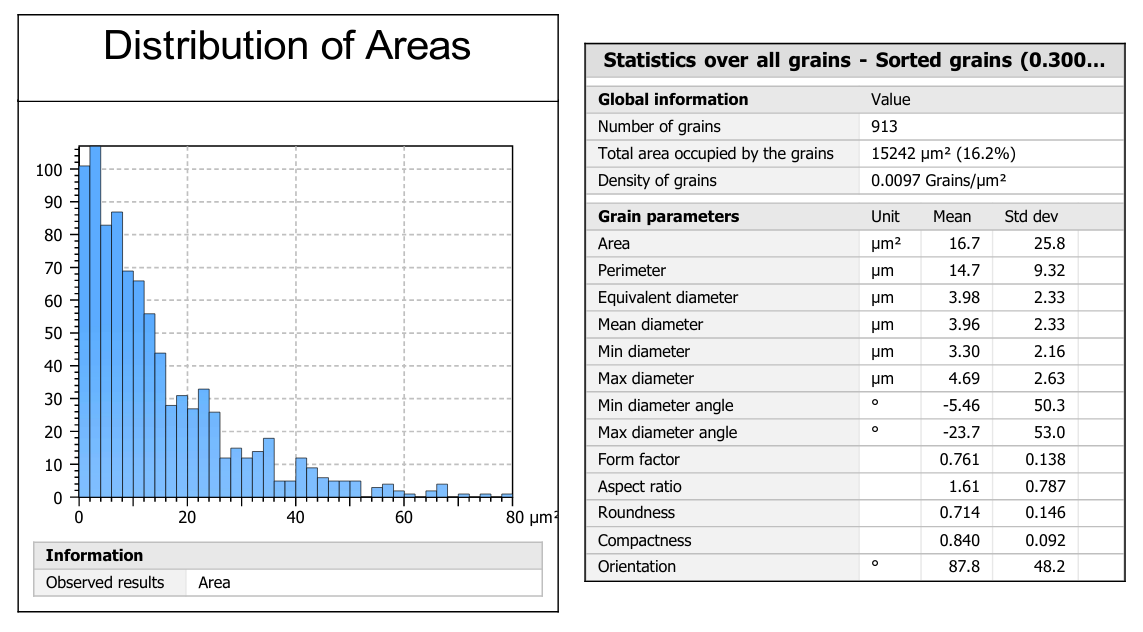


In [ ]:
particles_raw = tifffile.imread("data/Particle.tif")
fig, ax =  plt.subplots()
ax.imshow(particles_raw)

### Extracting Scale Bar

I zoomed in on the image and figured out which pixel are the scale bar then used them

In [ ]:
# subset the array - I already looked and know that these values are good

arr = particles_raw[960:, 850:900]

# take a line that we know is the bar
bar = arr[10, :]

fig, axs = plt.subplots(2,1)
axs[0].imshow(arr)
axs[1].plot(bar, "o-")

In [ ]:
bar > 10

In [ ]:
np.arange(len(bar))

In [ ]:
idxs = np.arange(len(bar)) * (bar > 10)
idxs


In [ ]:
idxs = np.arange(len(bar)) * (bar > 10)
scale_bar_length_pixels = idxs.max() - idxs.min()
scale_bar_length_micron = 10
pixels_per_micron = scale_bar_length_pixels / scale_bar_length_micron
microns_per_pixel = 1 / pixels_per_micron

In [ ]:
particles = particles_raw[:960]
particles.shape

In [ ]:
particles = particles_raw[:960]
particles = xr.DataArray(
    particles,
    dims=("Y", "X"),
    coords={
        "Y": np.linspace(0, particles.shape[0] * microns_per_pixel, particles.shape[0]),
        "X": np.linspace(0, particles.shape[1] * microns_per_pixel, particles.shape[1])
    },
)

In [ ]:
plt.figure()
xr.plot.imshow(particles)

## Thresholding


### Interactively


Sometimes it's nice to make a human judgement. This is easy to do using existing tools in the python ecosystem.  Here we use code taken nearly verbatim from an example on https://mpl-interactions.readthedocs.io/en/stable/examples/range-sliders.html#Using-a-RangeSlider-for-Scalar-arguments---Thresholding-an-Image


To make it easy to use we've also wrapped it up into a function that we can call easily on an array.

In [ ]:
import mpl_interactions.ipyplot as iplt

from nesm_utils import interactive_threshold

controls, axes = interactive_threshold(particles.values, bins=np.arange(0, 255))

In [ ]:
controls.params

In [ ]:
ds = xr.Dataset({'image': particles})

In [ ]:
ds['mask'] = particles > controls.params['vmin']
ds

## Breakout Exercise

Interactively choosing thresholds does not scale 

1. Make a plot comparing multiple thresholding methods (https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html)
    - Hint: You may need to use `particles.values` as xarray is not always completely interoperable with skimage
2. Segment the particles into individual labels
    - I would google something like: `segment particles skimage`
    - `skimage.measure.label` is appealing but isn't the optimal function.
3. Make a histogram of area of the particles
    - Any of these functions will let you get the areas
         - `np.unique`
         - `ndi.sum_labels`
         - `skimage.measure.regionprops`
    - Make a histogram using `plt.hist`


In [ ]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(particles.values, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
ds

In [ ]:
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed

threshold = threshold_otsu(ds["image"].values)
ds["mask"] = ds["image"] > threshold


distance = ndi.distance_transform_edt(ds["mask"])
coords = peak_local_max(distance, min_distance=2)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ds["labels"] = (("Y", "X"), watershed(-distance, markers, mask=ds["mask"].values))


plt.figure()
plt.imshow(ds["mask"])

plt.figure()
plt.imshow(distance)

plt.figure()
plt.imshow(ds["labels"])

In [ ]:
def individualize_single_frame(mask, min_distance=10):
    """
    Parameters
    ----------
    mask : (M, N) arraylike

    Returns
    -------
    labels : (M, N) array
    """
    distance = ndi.distance_transform_edt(mask)
    coords = peak_local_max(distance, min_distance=min_distance)
    peaks = np.zeros(distance.shape, dtype=bool)
    peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(peaks)
    labels = watershed(-distance, markers, mask=mask)
    return labels
plt.figure()
ctrls = iplt.imshow(lambda min_dist: individualize_single_frame(ds['mask'], min_dist) , min_dist=np.arange(1, 50))


In [ ]:
# ids, counts = np.unique(labels, return_counts=True)
# min_count = 10
# for label in ids[counts < min_count]:
#     labels[labels == label] = 0
# return relabel_sequential(labels)[0]

## End Breakout


Removing small objects


In [ ]:
from skimage.morphology import remove_small_objects
from skimage.segmentation import relabel_sequential

In [ ]:
ds['labels'].values = relabel_sequential(remove_small_objects(ds['labels'].values, 2))[0]

In [ ]:
ids, counts = np.unique(ds['labels'], return_counts=True)
fig, ax = plt.subplots()
ax.hist(counts[1:] / pixels_per_micron, bins=np.arange(0, 100, 1))
ax.set_xlim([0, 80])

In [ ]:
from skimage import measure

In [ ]:
import pandas as pd

df = pd.DataFrame(
    measure.regionprops_table(
        ds['labels'].values,
        properties=[
            "eccentricity",
            "filled_area",
            "equivalent_diameter",
            "orientation",
            "solidity",
            "perimeter",
            "area",
            "local_centroid",
            "minor_axis_length",
            "major_axis_length",
        ],
    )
)
df

In [ ]:
roundness = df['minor_axis_length'] / df['major_axis_length']
print(np.mean(roundness))
# plt.figure()

In [ ]:
df["circularity"] = (4 * np.pi * df["area"]) / df["perimeter"] ** 2

In [ ]:
df

In [ ]:
df.hist("circularity", bins=100)

In [ ]:
plt.figure()
plt.scatter("circularity", "eccentricity", data=df)
plt.ylabel("eccentricity")
plt.xlabel("circularity")

### Cell Tracking


Adjacent problem to what we did with the SEM image.

Again going to be loading in the cell nuclei dataset.

In [ ]:
import glob
import xarray as xr

files = sorted(glob.glob("data/Fluo-N3DH-CHO/01/*"))
cho_data = tifffile.imread(files)
CHO = xr.DataArray(
    cho_data,
    dims=("T", "Z", "Y", "X"),
    coords={
        "T": 9.5 * np.arange(cho_data.shape[0]),
        "Z": 1.0 * np.arange(cho_data.shape[1]),
        "Y": 0.202 * np.arange(cho_data.shape[2]),
        "X": 0.202 * np.arange(cho_data.shape[3]),
    },
)
sq = CHO.sel(Z=3)

In [ ]:
xr.Dataset({"images": sq})

In [ ]:
from mpl_interactions import hyperslicer

plt.figure()
hyperslicer(CHO)

## Breakout

### Part 1 - Segmenting a single frame

Using similar code to what you used for segmenting the SEM particle image segment the first frame of the cells image.


Hint: You may find that `ndi.binary_fille_holes` to be useful

In [ ]:
import scipy.ndimage as ndi

arr = CHO.values[1, 0]
thresholded = arr > 40
plt.figure()
plt.imshow(thresholded)
plt.imshow(ndi.binary_fill_holes(thresholded))

In [ ]:
mask1 = remove_small_objects(ndi.binary_fill_holes(CHO[0,1] > 20), connectivity=2)
mask2 = remove_small_objects(ndi.binary_fill_holes(CHO[1,1] > 20),connectivity=2)

In [ ]:
plt.figure()
plt.imshow(mask1)
plt.imshow(individualize_single_frame(mask1, min_distance=20))
plt.imshow(individualize_single_frame(mask2, min_distance=20))

In [ ]:
%load_ext autoreload
%autoreload 2
import nesm_utils as nu


In [ ]:
def individualize_single_frame(mask, min_distance=10):
    """
    Parameters
    ----------
    mask : (M, N) arraylike

    Returns
    -------
    labels : (M, N) array
    """
    distance = ndi.distance_transform_edt(mask)
    coords = peak_local_max(distance, min_distance=min_distance)
    peaks = np.zeros(distance.shape, dtype=bool)
    peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(peaks)
    labels = watershed(-distance, markers, mask=mask, connectivity=2)
    return labels, peaks


In [ ]:
# from skimage.mor
# image = ndi.binary_fill_holes(thresholded)
# distance = ndi.distance_transform_edt(image)
# coords = peak_local_max(distance, min_distance=50, footprint=np.ones((3, 3)), labels=image)
# mask = np.zeros(distance.shape, dtype=bool)
# mask[tuple(coords.T)] = True
# markers, _ = ndi.label(mask)
# labels = watershed(-distance, markers, mask=image)

## Part 2

Apply this segmenting to all of the time points. 
- It's ok to use a Python for loop here
- Making a function will make your life easier

Bonus: Get fancy and use `xr.apply_ufunc`. This is a bit more advanced but can be very powerful - we use this in our own cell segmenting and tracking pipeline.
http://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html


### End Breakout
----------------

Fixing Watershed using Human in the loop with Napari

Tracking cells through time

In [ ]:
images = CHO[:3, 2]
labels = []
peaks = []
blarg = []
thresh = 10
# for t in range(CHO.shape[0]):
for t in range(len(images)):
    a = remove_small_objects(ndi.binary_fill_holes(images[t] > thresh),connectivity=2)
    labels, peak_mask = individualize_single_frame(a)
    blarg.append(labels)
    peaks.append(peak_mask)

labels = np.asarray(blarg)
peaks = np.asarray(peaks)
orig_labels = np.copy(labels)
# labels_layer = correct_watershed(images, labels, peaks)

In [ ]:
nu.correct_watershed(images, labels, peaks)

In [ ]:
tracked = nu.track(labels)

In [ ]:
nu.correct_watershed(images, labels, peaks)

### Breakout exercise


Using indexing make a plot showing the evolution of each cells area over time.

Hint: If cells are born later then it can be tricky to plot them. So start with the easy part and just plot the cells that we know exist in the first frame



### Extra Breakout Acitivity


## Closing Thoughts on this section


1. GUI vs Scripting
2. If you make scripts make them available to others!
    - Put up on github with a name
3. If you're at a company - consider open sourcing at least part of your software (see tensorflow)

## How to get help!

1. Always always always google a phrase that basically says what you want.

Here are some of the things that I googled when making this notebook:

> how to analyze EDS python

> Cell tracking python

> remove small object skimage


In general people are friendly and want to know how you are using their software and what doesn't work for you:

- https://forum.image.sc/
- https://discourse.matplotlib.org/
- https://stackoverflow.com/
- https://discourse.jupyter.org/
- https://gitter.im/hyperspy/hyperspy
Opening issues!
